In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import matplotlib.pyplot as plt

In [3]:
# CRIM - 인구당 범죄율(마을별)
# ZN - 25,000 평방피트 이상의 대형 주거 지역 비율 -0으로 대체 가능? - corr이 0.4라 대충 대체해도 커버 가능. 
# INDUS - 마을별 비소매 사업지 비율 -평균으로 채우기.
# CHAS - 찰스강 더미 변수 (강과 인접한 지역은 1, 아니면 0) - 어차피 안씀. 0으로 대체
# NOX - 질소산화물 농도 (1000만 분의 1 기준)
# RM - 주택당 평균 방 수
# AGE - 1940년 이전에 지어진 자가 점유 주택 비율
# DIS - 보스턴 주요 5개 고용 센터까지의 가중 거리
# RAD - 방사형 고속도로 접근성 지수
# TAX - $10,000당 부동산 세율
# PTRATIO - 마을별 학생-교사 비율
# B - 1000(Bk - 0.63)^2 (Bk는 마을별 흑인 비율)
# LSTAT - 저소득층 인구 비율(%) - MEDV와 비례하여 대체. 
# MEDV - 자가 점유 주택의 중간 가격 ($1,000 단위)

#데이터 프레임 호출
df = pd.read_csv('housingdata.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [4]:
#데이터 프레임 분석
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
#결측치 검색.
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [6]:
#결측치 처리.
df['CRIM'] = df.loc[:,'CRIM'].fillna(df['CRIM'].mean())
df['ZN'] = df.loc[:,'ZN'].fillna(0)
df['INDUS'] = df.loc[:,'INDUS'].fillna(df['INDUS'].mean())
df['CHAS'] = df.loc[:,'CHAS'].fillna(0)
df['AGE'] = df.loc[:,'AGE'].fillna(df['AGE'].mean())
df = df.dropna() #LSTAT는 상관관계가 높아 임의로 입력시 오류가 클 수 있다. 따라서 제외하고 학습을 수행. 
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [7]:
#0.3 이하 : 상관 관계 사실상 없음. 
#0.5 이하 : 약한 상관관계 
#0.7 이하 : 강한 상관관계
#0.7~1 : 매우 강한 상관관계. 

#타겟값과 상관관계 분석. 
corr_matrix = df.corr()['MEDV'] #타겟값과 다른 컬럼간의 상관관계 출력.
corr_matrix = corr_matrix.drop('MEDV') #타겟값 자신과의 상관관계 삭제.
corr_matrix


CRIM      -0.376463
ZN         0.369984
INDUS     -0.477016
CHAS       0.183282
NOX       -0.424773
RM         0.692123
AGE       -0.375117
DIS        0.248831
RAD       -0.383306
TAX       -0.468589
PTRATIO   -0.512642
B          0.338656
LSTAT     -0.735822
Name: MEDV, dtype: float64

In [8]:
# 특정 열의 이상치 확인 (IQR 방법)
def count_outlier(df, column):
    Q1 = df[column].quantile(0.25) #
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR #상한치 
    upper_bound = Q3 + 1.5 * IQR #하한치
    count = 0
    # 이상치 확인    
    for i in range(len(df)):
        if df[column].iloc[i] < lower_bound or df[column].iloc[i] > upper_bound:
            count +=1 # 이상치 개수 count

    print(column, count)

for i in corr_matrix.index.to_list():  
    count_outlier(df,i) #이상치 존재하는 컬럼 확인. 

CRIM 60
ZN 61
INDUS 0
CHAS 33
NOX 0
RM 29
AGE 0
DIS 5
RAD 0
TAX 0
PTRATIO 0
B 74
LSTAT 7


In [9]:
#outlier 처리. 
def replace_outliers(df, column): #outlier 값 대체용 함수 정의
    Q1 = df[column].quantile(0.25)  # 1사분위수
    Q3 = df[column].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1  # IQR 계산

    lower_bound = Q1 - 1.5 * IQR  # 하한
    upper_bound = Q3 + 1.5 * IQR  # 상한

    # 이상치를 대체할 중간값 계산
    median_value = df[column].median()
 
    
    # iloc를 사용하여 이상치를 q1,q3값으로 변경. 위쪽으로 벗어났을 경우 q3, 밑으로 벗어났을 경우 q1
    for i in range(len(df)):
        if df[column].iloc[i] < lower_bound :
            df.iloc[i, df.columns.get_loc(column)] = lower_bound
        elif df[column].iloc[i] > upper_bound:
            df.iloc[i, df.columns.get_loc(column)] = upper_bound

#outlier 값 대체
replace_colunm = ['ZN','RM','DIS', 'LSTAT'] #outlier 처리할 컬럼 지정. 
for i in replace_colunm :
    replace_outliers(df,i)


In [10]:
# #각 컬럼 데이터 시각화. 
# for i in corr_matrix.index.to_list():
#     print(i)
#     plt.plot(df[i])
#     plt.show()

In [11]:
#상관관계의 절대값이 throshold 이상인 컬럼만 사용. 
threshold = 0.4
input_column = corr_matrix[abs(corr_matrix) >= threshold].index.to_list()
target_column = ['MEDV'] #타겟값 지정. 
print(input_column)

#입력 데이터와 타겟 데이터 분리. 
X = df[input_column]
y = df[target_column]

# 데이터 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# 데이터 분할 (훈련 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y 값 1차원으로 수정. 
y_train = y_train.ravel()
y_test = y_test.ravel()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
(388, 6)
(388,)
(98, 6)
(98,)


Mean Squared Error: 0.3452024346717301
Mean absolute_ Error: 0.40678580617719856
R^2 Score: 0.6705241127681048
Mean Squared Error: 0.22239201924963972
Mean absolute_ Error: 0.3645380857056819
R^2 Score: 0.7218927458002214


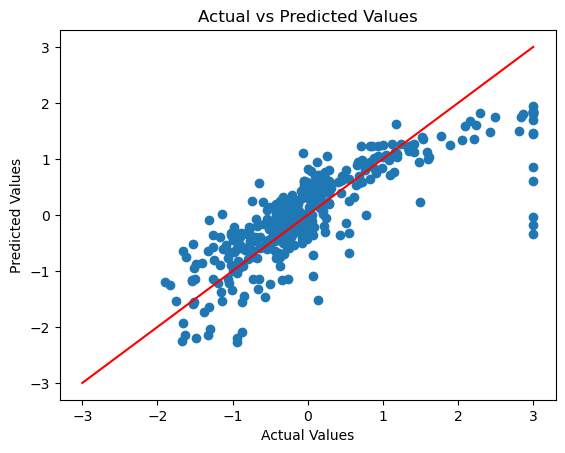

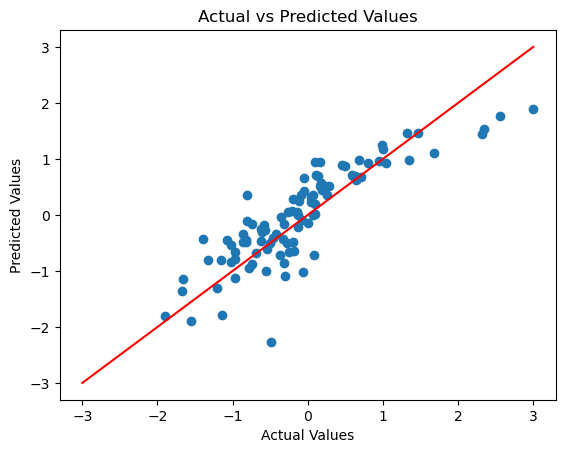

In [12]:
# 선형 회귀 모델 생성
model = LinearRegression()

# 모델 학습
model.fit(X_train, y_train)

#학습 수준 평가. 
mse = mean_squared_error(y_train,model.predict(X_train))
mae = mean_absolute_error(y_train,model.predict(X_train))
r2 = r2_score(y_train,model.predict(X_train))

print(f'Mean Squared Error: {mse}')
print(f'Mean absolute_ Error: {mae}')
print(f'R^2 Score: {r2}')
LR_train = [mae,mse, r2]

#모델 성능 평가. 
mse = mean_squared_error(y_test,model.predict(X_test))
mae = mean_absolute_error(y_test,model.predict(X_test))
r2 = r2_score(y_test,model.predict(X_test))

print(f'Mean Squared Error: {mse}')
print(f'Mean absolute_ Error: {mae}')
print(f'R^2 Score: {r2}')
LR_test = [mae,mse,r2]

# 학습 수준 시각화
plt.scatter(y_train, model.predict(X_train))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

#테스트 시각화
plt.scatter(y_test,model.predict(X_test))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
Best Score (Neg MSE): 0.7777551187662901
Mean Squared Error: 0.11306192858032181
Mean Absolute Error: 0.22244379520848545
R^2 Score: 0.8920888861442282
Mean Squared Error: 0.14756226758696275
Mean absolute_ Error: 0.28665861397522424
R^2 Score: 0.8154693805984241


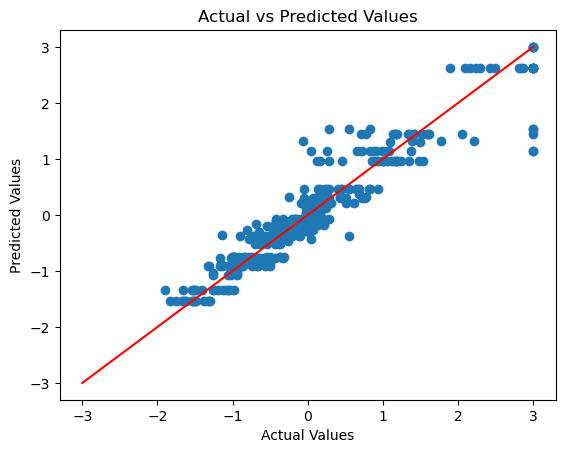

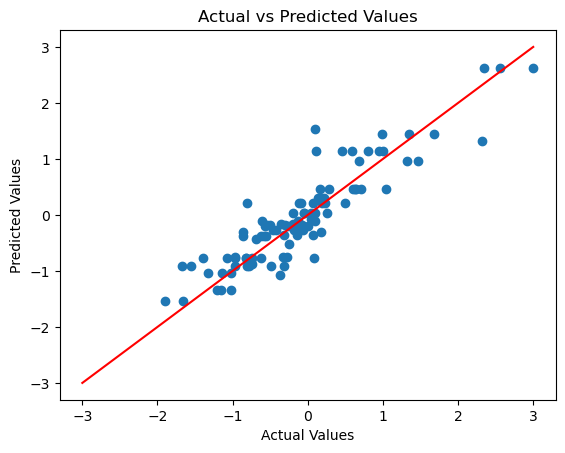

In [13]:
#의사결정 나무 모델.
model = DecisionTreeRegressor(random_state=42)  #모델 선언

#grid search 파라미터 선언. 
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4],
}

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)

# gird search 수행. 
grid_search.fit(X_train, y_train)

# gird search 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Neg MSE):", grid_search.best_score_)

#grid search로 구한 파라미터 사용. 
model = DecisionTreeRegressor(**grid_search.best_params_,random_state=42) 
model.fit(X_train, y_train) #모델 학습
y_pred = model.predict(X_test) # x테스트 데이터 예측

#모델 학습 수준 평가. 
mse = mean_squared_error(y_train,model.predict(X_train))
mae = mean_absolute_error(y_train,model.predict(X_train))
r2 = r2_score(y_train,model.predict(X_train))
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')
DT_train = [mse, mae, r2]

#모델 성능 테스트
mse = mean_squared_error(y_test,model.predict(X_test))
mae = mean_absolute_error(y_test,model.predict(X_test))
r2 = r2_score(y_test,model.predict(X_test))

print(f'Mean Squared Error: {mse}')
print(f'Mean absolute_ Error: {mae}')
print(f'R^2 Score: {r2}')
DT_test = [mae,mse, r2]

# 학습 수준 시각화
plt.scatter(y_train, model.predict(X_train))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

#테스트 결과 시각화
plt.scatter(y_test,model.predict(X_test))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8374706375653812
Mean Squared Error: 0.02301302742128905
Mean Absolute Error: 0.10208394297216823
R^2 Score: 0.9780353877436251
Mean Squared Error: 0.10190006080461639
Mean absolute_ Error: 0.2300972278668192
R^2 Score: 0.8725712091253102


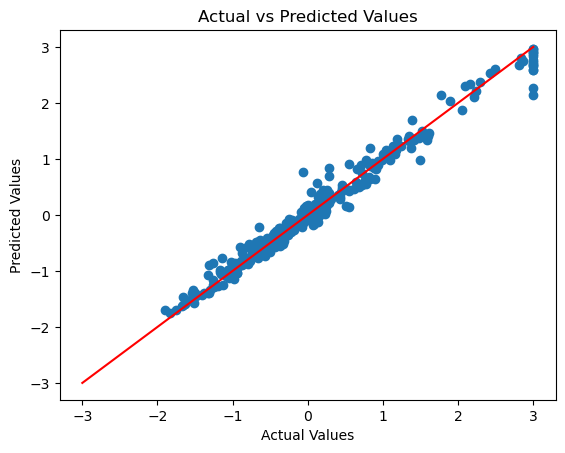

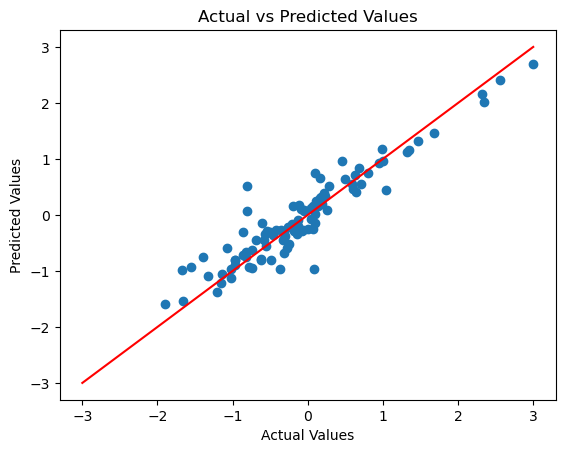

In [14]:

#랜덤 포레스트 모델
model = RandomForestRegressor(random_state= 42) #랜덤 포레스트 모델 선언. 

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [10, 50, 100,200,400,600],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 실행
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

#하이퍼 파리미터 조정 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

 #최적화 파라미터 조건에서의 모델 선언. 
model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
model.fit(X_train, y_train) # 모델 학습
y_pred = model.predict(X_test) # 테스트 데이터 예측값 생성

#학습 데이터에 대한 성능 지표 계산. 
mse = mean_squared_error(y_train,model.predict(X_train))
mae = mean_absolute_error(y_train,model.predict(X_train))
r2 = r2_score(y_train,model.predict(X_train))

#성능 지표 출력. 
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')
RF_train = [mse, mae, r2] #성능 비교를 위한 지표값 리스트 

mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean absolute_ Error: {mae}')
print(f'R^2 Score: {r2}')
RF_test = [mae,mse, r2]

#학습 결과 시각화
plt.scatter(y_train,model.predict(X_train))
plt.plot([-3, 3], [-3, 3], color='red') #
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

#테스트 결과 시각화
plt.scatter(y_test,y_pred)
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Score: 0.8572223084004594
Mean Squared Error: 0.06357169399280656
Mean Absolute Error: 0.1817415072296897
R^2 Score: 0.9393244711584018
Mean test Squared Error: 0.09381646218490526
Mean test Absolute Error: 0.23444985010370772
R^2 test Score: 0.8826799685302843


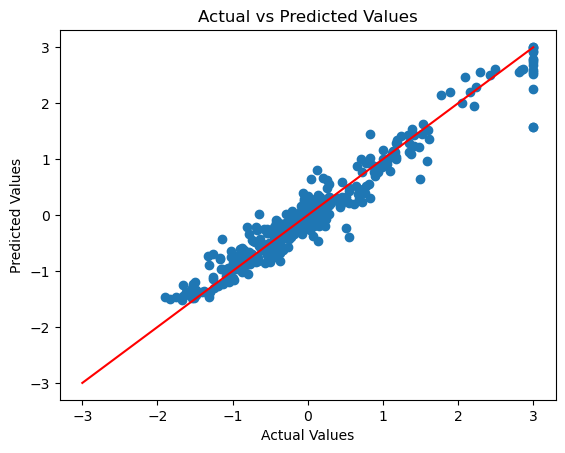

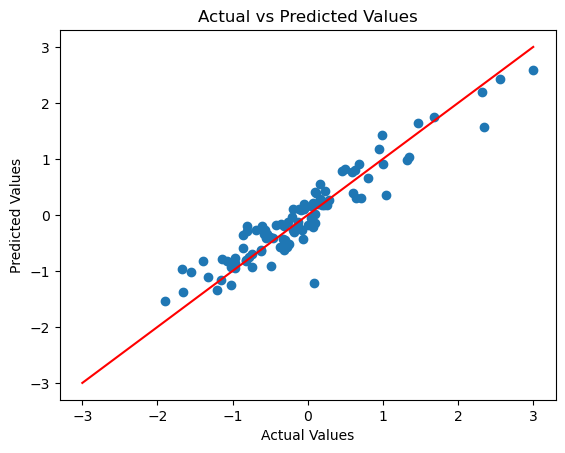

In [ ]:
# 익스트림 그래디언트 부스트 모델 선언
model = xgb.XGBRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200,400,600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# GridSearchCV 실행
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 결과 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

#최적값 기준으로 모델 재선언
model = xgb.XGBRegressor(**grid_search.best_params_,random_state=42)
model.fit(X_train, y_train) # 모델 학습
y_pred = model.predict(X_test) # 테스트 데잍 예측값 생성

# 모델 학습 수준 평가. 
mse = mean_squared_error(y_train,model.predict(X_train))
mae = mean_absolute_error(y_train,model.predict(X_train))
r2 = r2_score(y_train,model.predict(X_train))
xgb_train = [mse, mae, r2] #성능 비교를 위한 학습 데이터에 대한 지표값 리스트 

# 모델 성능 평가. 
mse_test = mean_squared_error(y_test,model.predict(X_test))
mae_test = mean_absolute_error(y_test,model.predict(X_test))
r2_test = r2_score(y_test,model.predict(X_test))
xgb_test = [mse_test, mae_test, r2_test] #성능 비교를 위한 테스트 데이터에 대한한 지표값 리스트 

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

print(f'Mean test Squared Error: {mse_test}')
print(f'Mean test Absolute Error: {mae_test}')
print(f'R^2 test Score: {r2_test}')

#예측값 vs 실제 값 시각화
plt.scatter(y_train,model.predict(X_train))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

#테스트 시각화
plt.scatter(y_test,model.predict(X_test))
plt.plot([-3, 3], [-3, 3], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

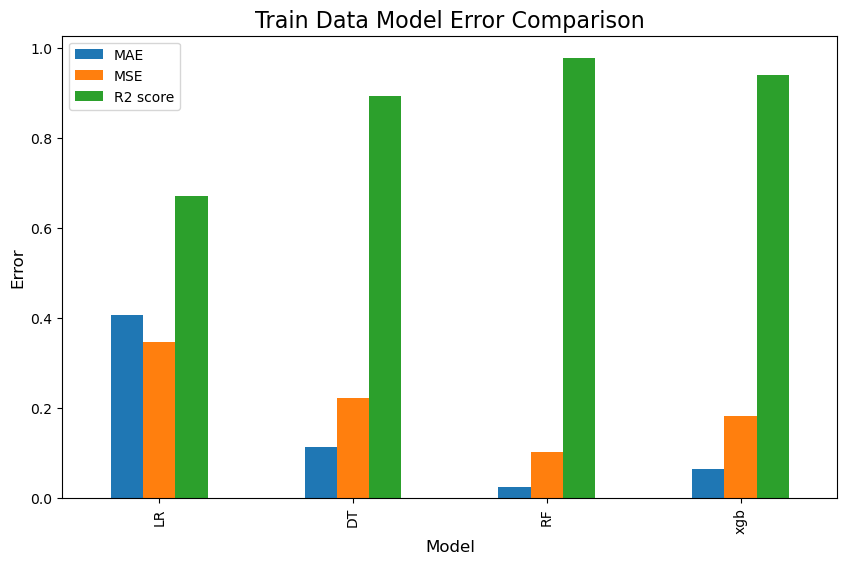

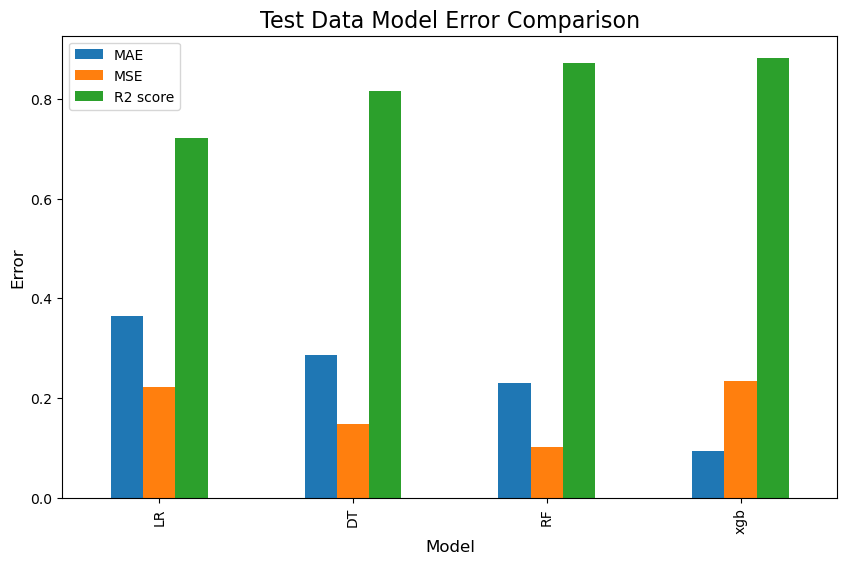

In [ ]:
# 학습 데이터에 대한 오차
error_data = {'LR' : LR_train,
              'DT' : DT_train,
              'RF' : RF_train,
              'xgb': xgb_train}
error_df = pd.DataFrame(error_data)
error_df = error_df.transpose()
error_df.columns = ['MAE','MSE', 'R2 score']

error_df.plot(kind='bar', figsize=(10, 6))

# 그래프 제목과 레이블 추가
plt.title('Train Data Model Error Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error', fontsize=12)

# 그래프 출력
plt.show()

# 테스트 데이터에 대한 오차
test_error_data = {'LR' : LR_test,
              'DT' : DT_test,
              'RF' : RF_test,
              'xgb': xgb_test}
test_error_df = pd.DataFrame(test_error_data)
test_error_df = test_error_df.transpose()
test_error_df.columns = ['MAE','MSE', 'R2 score']
test_error_df.plot(kind='bar', figsize=(10, 6))

# 그래프 제목과 레이블 추가
plt.title('Test Data Model Error Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error', fontsize=12)

# 그래프 출력
plt.show()



In [17]:
# 학습 데이터 오차 데이터 프레임
error_df

,MAE,MSE,R2 score
LR,0.406786,0.345202,0.670524
DT,0.113062,0.222444,0.892089
RF,0.023013,0.102084,0.978035
xgb,0.063572,0.181742,0.939324


In [18]:
# 테스트 데이터 오차 데이터 프레임
test_error_df

,MAE,MSE,R2 score
LR,0.364538,0.222392,0.721893
DT,0.286659,0.147562,0.815469
RF,0.230097,0.101900,0.872571
xgb,0.093816,0.234450,0.882680
